# An example of reference mapping using user-owned reference dataset

In [11]:
import numpy as np
import scanpy as sc
import sys
import os
import warnings
import torch
from pathlib import Path
import json
import pandas as pd
from scipy.stats import mode

In [12]:
import torch

print(torch.__version__)

2.2.0


In [13]:
# extra dependency for similarity search
try:
    import hnswlib

    hnswlib_imported = True
except ImportError:
    hnswlib_imported = False
    print(
        "hnswlib not installed! We highly recommend installing it for fast similarity search."
    )
    print("To install it, run: pip install hnswlib")

sys.path.insert(0, "../")

In [14]:
from scgpt.loss import masked_mse_loss, masked_relative_error
from scgpt.model import TransformerModel
from scgpt.preprocess import Preprocessor
from scgpt.tokenizer import tokenize_and_pad_batch, random_mask_value
from scgpt.tokenizer.gene_tokenizer import GeneVocab
from scgpt import logger
from scgpt import SubsetsBatchSampler
import sklearn

## some  functions

In [15]:
def get_batch_cell_embeddings(
    adata,
    cell_embedding_mode: str = "cls",
    model=None,
    vocab=None,
    max_length=1200,
    model_configs=None,
    gene_ids=None,
    use_batch_labels=False,
) -> np.ndarray:
    """
    Get the cell embeddings for a batch of cells.

    Args:
        adata (AnnData): The AnnData object.
        gene_embs (np.ndarray): The gene embeddings, shape (len(vocab), d_emb).
        count_matrix (np.ndarray): The count matrix.

    Returns:
        np.ndarray: The cell embeddings.
    """
    count_matrix = (
        adata.layers["counts"]
        if isinstance(adata.layers["counts"], np.ndarray)
        else adata.layers["counts"].A
    )
    
    # Ensure count_matrix is a proper numpy array with copy to avoid issues
    count_matrix = np.array(count_matrix, dtype=np.float32)

    # gene vocabulary ids
    if gene_ids is None:
        gene_ids = np.array(adata.var["id_in_vocab"])
        assert np.all(gene_ids >= 0)
    
    # Ensure gene_ids is a proper numpy array
    gene_ids = np.array(gene_ids, dtype=np.int64)

    if use_batch_labels:
        batch_ids = np.array(adata.obs["batch_id"].tolist())

    elif cell_embedding_mode == "cls":
        tokenized_all = tokenize_and_pad_batch(
            count_matrix,
            gene_ids,
            max_len=max_length,
            vocab=vocab,
            pad_token=model_configs["pad_token"],
            pad_value=model_configs["pad_value"],
            append_cls=True,  # append <cls> token at the beginning
            include_zero_gene=False,
        )
        all_gene_ids, all_values = tokenized_all["genes"], tokenized_all["values"]
        src_key_padding_mask = all_gene_ids.eq(vocab[model_configs["pad_token"]])
        # Disable CUDA AMP since we're using CPU on Mac
        with torch.no_grad():
            cell_embeddings = model.encode_batch(
                all_gene_ids,
                all_values.float(),
                src_key_padding_mask=src_key_padding_mask,
                batch_size=8,
                batch_labels=None,
                time_step=0,
                return_np=True,
            )
        cell_embeddings = cell_embeddings / np.linalg.norm(
            cell_embeddings, axis=1, keepdims=True
        )
    else:
        raise ValueError(f"Unknown cell embedding mode: {cell_embedding_mode}")
    return cell_embeddings

In [16]:
adata = sc.read_h5ad(
    "/Users/vedran/Downloads/251020_blood_atlas.h5ad"
)
cell_type_key = "cell_type"
assert cell_type_key in adata.obs

gene_col = "index"
if gene_col == "index":
    adata.var["index"] = adata.var.index
else:
    assert gene_col in adata.var

n_hvg = max_seq_len = 1200
DO_HVG = True
HAS_BATCH = batch_key = None

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [17]:
# Load model vocabulary and configuration
model_dir = Path("/Users/vedran/Downloads/scGPT")  # Update this path to your model directory
vocab_file = model_dir / "vocab.json"
model_config_file = model_dir / "args.json"
model_file = model_dir / "best_model.pt"
pad_token = "<pad>"
special_tokens = [pad_token, "<cls>", "<eoc>"]

# Load vocabulary
vocab = GeneVocab.from_file(vocab_file)
for s in special_tokens:
    if s not in vocab:
        vocab.append_token(s)

vocab.set_default_index(vocab["<pad>"])

# Match genes to vocabulary
adata.var["id_in_vocab"] = [
    vocab[gene] if gene in vocab else -1 for gene in adata.var[gene_col]
]
gene_ids_in_vocab = np.array(adata.var["id_in_vocab"])
logger.info(
    f"match {np.sum(gene_ids_in_vocab >= 0)}/{len(gene_ids_in_vocab)} genes "
    f"in vocabulary of size {len(vocab)}."
)
adata = adata[:, adata.var["id_in_vocab"] >= 0]

# Load model configuration
with open(model_config_file, "r") as f:
    model_configs = json.load(f)

scGPT - INFO - match 9142/9202 genes in vocabulary of size 60697.


In [18]:
data_is_raw = adata.X.max() > 30
print("data is raw: ", data_is_raw)
preprocessor = Preprocessor(
    use_key="X",  # the key in adata.layers to use as raw data
    filter_gene_by_counts=False,  # step 1
    filter_cell_by_counts=False,  # step 2
    normalize_total=1e4,  # 3. whether to normalize the raw data and to what sum
    result_normed_key="X_normed",  # the key in adata.layers to store the normalized data
    log1p=data_is_raw,  # 4. whether to log1p the normalized data
    result_log1p_key="X_log1p",
    subset_hvg=n_hvg if DO_HVG else False,
    hvg_flavor="seurat_v3" if data_is_raw else "cell_ranger",
    binning=51,  # 6. whether to bin the raw data and to what number of bins
    result_binned_key="counts",  # the key in adata.layers to store the binned data
)
preprocessor(adata, batch_key=batch_key if HAS_BATCH else None)

# Get gene IDs for the preprocessed genes
genes = adata.var[gene_col].tolist()
gene_ids = np.array(vocab(genes), dtype=int)

if HAS_BATCH:
    adata.obs["batch_id"] = adata.obs[batch_key].astype("category").cat.codes.values
else:
    adata.obs["batch_id"] = adata.obs[cell_type_key].astype("category").cat.codes.values
batch_ids = adata.obs["batch_id"].tolist()
num_batch_types = len(set(batch_ids))
batch_ids = np.array(batch_ids)

# # Tokenize input
if isinstance(adata.layers["counts"], np.ndarray):
    all_counts = adata.layers["counts"]
else:
    all_counts = adata.layers["counts"].A

num_of_non_zero_genes = [
    np.count_nonzero(all_counts[i]) for i in range(all_counts.shape[0])
]

max_length = np.max(num_of_non_zero_genes) + 1  # plus 1 for appending <cls>
max_length = min(max_length, max_seq_len + 1)

data is raw:  True
scGPT - INFO - Normalizing total counts ...
scGPT - INFO - Log1p transforming ...
scGPT - INFO - Subsetting highly variable genes ...
scGPT - INFO - Log1p transforming ...
scGPT - INFO - Subsetting highly variable genes ...
scGPT - WARNING - No batch_key is provided, will use all cells for HVG selection.
scGPT - WARNING - No batch_key is provided, will use all cells for HVG selection.
scGPT - INFO - Binning data ...
scGPT - INFO - Binning data ...


/Users/vedran/git/Workflomics-related/bh25-Project7/biohackathon2025/scGPT/.venv/lib/python3.11/site-packages/scanpy/preprocessing/_normalization.py:269: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)


In [19]:
model = TransformerModel(
    ntoken=len(vocab),
    d_model=model_configs["embsize"],
    nhead=model_configs["nheads"],
    d_hid=model_configs["d_hid"],
    nlayers=model_configs["nlayers"],
    nlayers_cls=model_configs["n_layers_cls"],
    n_cls=1,
    vocab=vocab,
    dropout=model_configs["dropout"],
    pad_token=model_configs["pad_token"],
    pad_value=model_configs["pad_value"],
    do_mvc=True,
    do_dab=False,
    use_batch_labels=False,
    # num_batch_labels=num_batch_types,
    domain_spec_batchnorm=False,
    explicit_zero_prob=False,
    use_fast_transformer=True,
    fast_transformer_backend="flash",
    pre_norm=False,
)

import torch

# Load the checkpoint
checkpoint = torch.load(model_file, map_location=device)

# Handle naming differences between PyTorch 1.x and 2.x Transformer layers
state_dict = checkpoint

# Map "Wqkv" -> "in_proj_weight"/"in_proj_bias" if needed
mapped_state_dict = {}
for k, v in state_dict.items():
    if "Wqkv.weight" in k:
        base = k.replace("Wqkv.weight", "")
        # Split Wqkv.weight into in_proj_weight format if possible
        mapped_state_dict[base + "in_proj_weight"] = v
    elif "Wqkv.bias" in k:
        base = k.replace("Wqkv.bias", "")
        mapped_state_dict[base + "in_proj_bias"] = v
    else:
        mapped_state_dict[k] = v

# Load model parameters, ignoring missing/unexpected keys safely
model_dict = model.state_dict()
pretrained_dict = {
    k: v for k, v in mapped_state_dict.items()
    if k in model_dict and v.shape == model_dict[k].shape
}
model_dict.update(pretrained_dict)
model.load_state_dict(model_dict, strict=False)

model.to(device)
model.eval()


# model.load_state_dict(torch.load(model_file, map_location=device))

# try:
#     model.load_state_dict(torch.load(model_file, map_location=device))
# except:
#     model_dict = model.state_dict()
#     pretrained_dict = torch.load(model_file)
#     pretrained_dict = {
#         k: v
#         for k, v in pretrained_dict.items()
#         if k in model_dict and v.shape == model_dict[k].shape
#     }
#     # for k, v in pretrained_dict.items():
#     #     logger.info(f"Loading params {k} with shape {v.shape}")
#     model_dict.update(pretrained_dict)
#     model.load_state_dict(model_dict)
# model.to(device)

# model.eval()

/Users/vedran/git/Workflomics-related/bh25-Project7/biohackathon2025/scGPT/.venv/lib/python3.11/site-packages/scgpt/model/model.py:77: UserWarning: flash-attn is not installed, using pytorch transformer instead. Set use_fast_transformer=False to avoid this warning. Installing flash-attn is highly recommended.
  warnings.warn(


TransformerModel(
  (encoder): GeneEncoder(
    (embedding): Embedding(60697, 512, padding_idx=60694)
    (enc_norm): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
  )
  (value_encoder): ContinuousValueEncoder(
    (dropout): Dropout(p=0.2, inplace=False)
    (linear1): Linear(in_features=1, out_features=512, bias=True)
    (activation): ReLU()
    (linear2): Linear(in_features=512, out_features=512, bias=True)
    (norm): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
  )
  (transformer_encoder): TransformerEncoder(
    (layers): ModuleList(
      (0-11): 12 x TransformerEncoderLayer(
        (self_attn): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=512, out_features=512, bias=True)
        )
        (linear1): Linear(in_features=512, out_features=512, bias=True)
        (dropout): Dropout(p=0.2, inplace=False)
        (linear2): Linear(in_features=512, out_features=512, bias=True)
        (norm1): LayerNorm((512,), eps=1e-05, el

In [20]:
ref_cell_embeddings = get_batch_cell_embeddings(
    adata,
    cell_embedding_mode="cls",
    model=model,
    vocab=vocab,
    max_length=max_length,
    model_configs=model_configs,
    gene_ids=gene_ids,
    use_batch_labels=False,
)

  0%|          | 0/20 [00:00<?, ?it/s]

/Users/vedran/git/Workflomics-related/bh25-Project7/biohackathon2025/scGPT/.venv/lib/python3.11/site-packages/torch/nn/modules/transformer.py:384: UserWarning: The PyTorch API of nested tensors is in prototype stage and will change in the near future. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/aten/src/ATen/NestedTensorImpl.cpp:179.)
  output = torch._nested_tensor_from_mask(output, src_key_padding_mask.logical_not(), mask_check=False)
100%|██████████| 20/20 [00:22<00:00,  1.12s/it]


In [ ]:
ref_cell_embeddings

array([[ 0.03130031, -0.03318056,  0.01778672, ..., -0.01698686,
         0.01793445, -0.00924435],
       [ 0.02845124, -0.03637465,  0.01876275, ..., -0.02115081,
         0.01740217, -0.01054861],
       [ 0.02893392, -0.03403684,  0.01754967, ..., -0.01908917,
         0.01874024, -0.00988673],
       ...,
       [ 0.0130463 , -0.04530964,  0.02968834, ..., -0.01388197,
         0.03344731, -0.00374468],
       [ 0.00685195, -0.0464806 ,  0.03103354, ..., -0.00820779,
         0.03079514, -0.00447047],
       [ 0.00866219, -0.04127946,  0.02611854, ..., -0.01062641,
         0.02692069, -0.00761785]], dtype=float32)

In [21]:
# Optional step to visualize the reference dataset using the embeddings
ref_embed_adata = sc.AnnData(ref_cell_embeddings, obs=pd.DataFrame(adata.obs))

sc.pp.neighbors(ref_embed_adata, use_rep="X")
sc.tl.umap(ref_embed_adata)


In [22]:
ref_embed_adata.obs[cell_type_key].tolist()

['Basophil',
 'Basophil',
 'Basophil',
 'Basophil',
 'Basophil',
 'CD4_CentralMemory',
 'CD4_CentralMemory',
 'CD4_CentralMemory',
 'CD4_CentralMemory',
 'CD4_CentralMemory',
 'CD4_CentralMemory',
 'CD4_EffectorMemory',
 'CD4_EffectorMemory',
 'CD4_EffectorMemory',
 'CD4_EffectorMemory',
 'CD4_EffectorMemory',
 'CD4_EffectorMemory',
 'CD4_TEMRA',
 'CD4_TEMRA',
 'CD4_TEMRA',
 'CD4_TEMRA',
 'CD4_TEMRA',
 'CD4_Naive',
 'CD4_Naive',
 'CD4_Naive',
 'CD4_Naive',
 'CD4_Naive',
 'CD4_Naive',
 'CD8_CentralMemory',
 'CD8_CentralMemory',
 'CD8_CentralMemory',
 'CD8_CentralMemory',
 'CD8_CentralMemory',
 'CD8_CentralMemory',
 'CD8_EffectorMemory',
 'CD8_EffectorMemory',
 'CD8_EffectorMemory',
 'CD8_EffectorMemory',
 'CD8_EffectorMemory',
 'CD8_EffectorMemory',
 'CD8_TEMRA',
 'CD8_TEMRA',
 'CD8_TEMRA',
 'CD8_TEMRA',
 'CD8_TEMRA',
 'CD8_TEMRA',
 'CD8_Naive',
 'CD8_Naive',
 'CD8_Naive',
 'CD8_Naive',
 'CD8_Naive',
 'CD8_Naive',
 'Eosinophil',
 'Eosinophil',
 'Eosinophil',
 'Eosinophil',
 'Eosinophil'

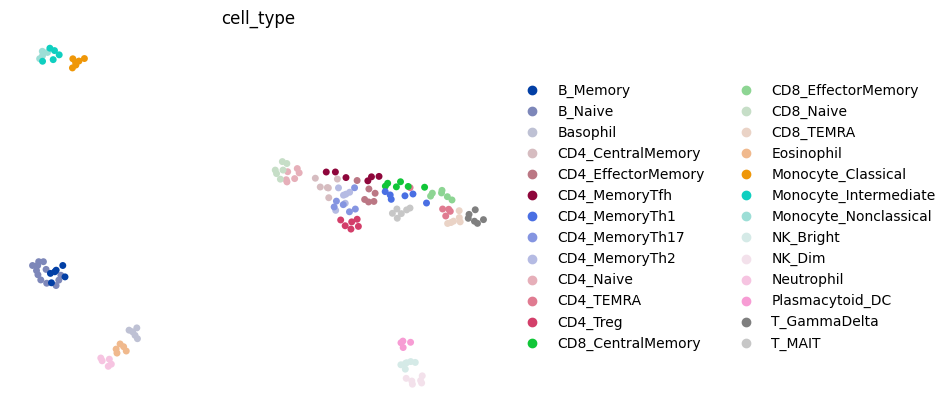

In [23]:
sc.pl.umap(ref_embed_adata, color=cell_type_key, frameon=False, wspace=0.4, size=100)

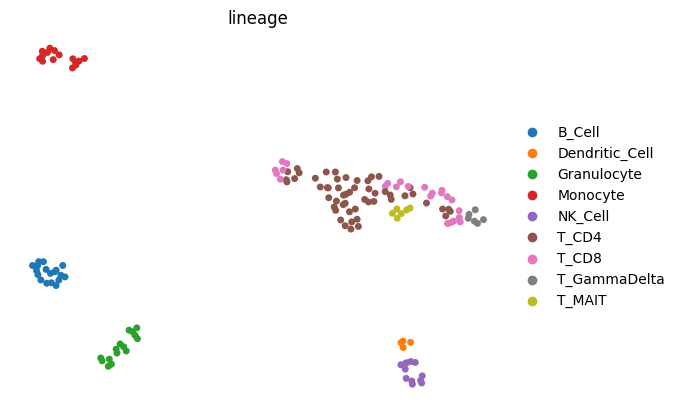

In [24]:
sc.pl.umap(ref_embed_adata, color="lineage", frameon=False, wspace=0.4, size=100)

In [25]:
test_adata = sc.read_h5ad("../data/annotation_pancreas/demo_test.h5ad")
if gene_col == "index":
    test_adata.var["index"] = test_adata.var.index

test_adata.var["id_in_vocab"] = [
    vocab[gene] if gene in vocab else -1 for gene in test_adata.var[gene_col]
]
test_adata = test_adata[:, test_adata.var["id_in_vocab"] >= 0]
preprocessor(test_adata, batch_key=batch_key if HAS_BATCH else None)

FileNotFoundError: [Errno 2] Unable to synchronously open file (unable to open file: name = '../data/annotation_pancreas/demo_test.h5ad', errno = 2, error message = 'No such file or directory', flags = 0, o_flags = 0)

In [ ]:
test_emebd = get_batch_cell_embeddings(
    test_adata,
    cell_embedding_mode="cls",
    model=model,
    vocab=vocab,
    max_length=max_length,
    model_configs=model_configs,
    gene_ids=np.array(vocab(test_adata.var[gene_col].tolist()), dtype=int),
    use_batch_labels=False,
)

In [ ]:
# # optional step to visualize the dataset
# test_embed_adata = sc.AnnData(
#     test_emebd,
#     obs=pd.DataFrame(test_adata.obs))
# sc.pp.neighbors(test_embed_adata, use_rep="X")
# sc.tl.umap(test_embed_adata)
# sc.pl.umap(test_embed_adata, color=cell_type_key, frameon=False, wspace=0.4)

## referrence mapping

In [ ]:
# Those functions are only used when hnswlib is not installed
def cos_sim(a, b):
    sims = a @ b.T
    sims /= np.linalg.norm(a) * np.linalg.norm(b, axis=1)
    return sims[0]


def l2_sim(a, b):
    sims = -np.linalg.norm(a - b, axis=1)
    return sims


def get_similar_vectors(vector, ref, top_k=10):
    # sims = cos_sim(vector, ref)
    sims = l2_sim(vector, ref)

    top_k_idx = np.argsort(sims)[::-1][:top_k]
    return top_k_idx, sims[top_k_idx]


def get_celltype(idx, adata):
    return adata.obs[cell_type_key][idx]

In [ ]:
k = 10  # number of neighbors

if hnswlib_imported:
    # Declaring index, using most of the default parameters from https://github.com/nmslib/hnswlib
    p = hnswlib.Index(
        space="l2", dim=ref_cell_embeddings.shape[1]
    )  # possible options are l2, cosine or ip
    p.init_index(max_elements=ref_cell_embeddings.shape[0], ef_construction=200, M=16)

    # Element insertion (can be called several times):
    p.add_items(ref_cell_embeddings, ids=np.arange(ref_cell_embeddings.shape[0]))

    # Controlling the recall by setting ef:
    p.set_ef(50)  # ef should always be > k

    # Query dataset, k - number of closest elements (returns 2 numpy arrays)
    labels, distances = p.knn_query(test_emebd, k=k)

idx_list = [i for i in range(test_emebd.shape[0])]
gt_list = []
pred_list = []
for k in idx_list:
    gt = test_adata.obs[cell_type_key][k]
    if hnswlib_imported:
        idx = labels[k]
    else:
        idx, sim = get_similar_vectors(
            test_emebd[k][np.newaxis, ...], ref_cell_embeddings
        )
    pred = mode(ref_embed_adata.obs[cell_type_key][idx], axis=0)
    gt_list.append(gt)
    pred_list.append(pred[0][0])

sklearn.metrics.accuracy_score(gt_list, pred_list)

In [ ]:
# optionally, the built index can be saved/loaded for future use
# if hnswlib_imported:
#     p.save_index("index.bin")
#     # the index can be loaded with
#     # p.load_index("index.bin", max_elements=...)